In [3]:
from torch import nn
import torch
import numpy as np

In [20]:
a = np.array([np.array([1,2,3,4,5,6,7]),np.array([1,2,3,4,5,6,7])])

a[:, :-5]

array([[1, 2],
       [1, 2]])

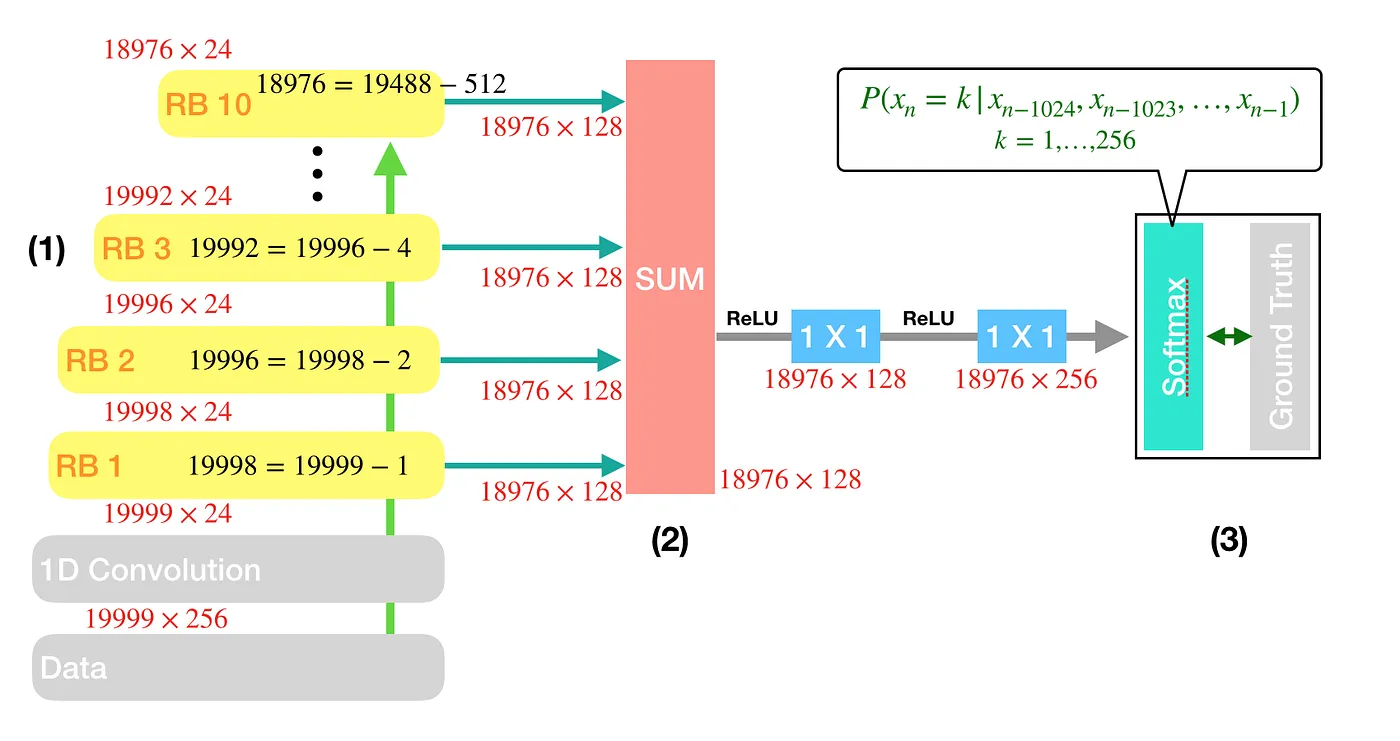
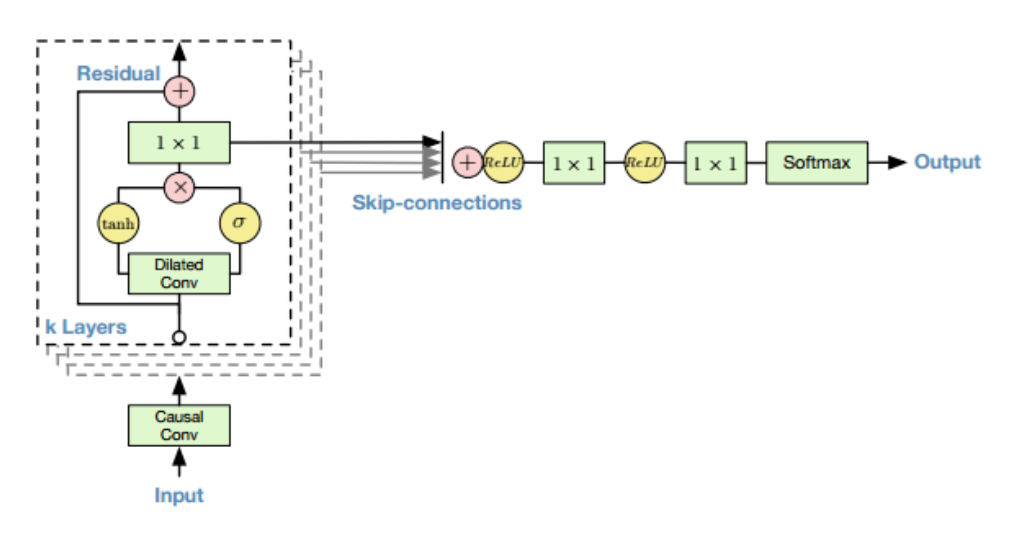

In [2]:
# !pip install dotsi
!pip install sounddevice


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 3.6 MB/s eta 0:00:00


In [21]:
#One hot encoding of the input based on the image above and the following article: https://medium.com/@kion.kim/wavenet-a-network-good-to-know-7caaae735435 
import torch.nn.functional as F

def one_hot(x, kernel_size):
    x = nn.functional.pad(x, (kernel_size - 1, kernel_size - 1)) #IF we don't need this need to add to input. 
    one_hot = F.one_hot(x, num_classes=256) 
    tf_shape = (1, -1, 256) #so rows actually are the points! I THINK! but then the way the conv channel works is weird... But image also shows like this 
    py_shape = (1, 256, -1)
    one_hot = torch.reshape(one_hot, py_shape)
    return one_hot


So in our case of one hot encoding, we have 256 channels of a sparse vector where dimensions are #samples, 256. We have told them the channels. Therefore it will automatically learn to create it as if going back as in 256 convlutions of kernel size summing over window at once. So it works as long as pre specified and order is correct.Channels usually at end for input I feel. But will have to reshape when passing via PYTORCH!

In [ ]:
#x is typically one channel where the timestemps depends on the frequency rate. Can be two though. Typically a 1D array 
class CasualDilatedConv1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        self.dilation - dilation
        self.kernel_size = kernel_size
        self.conv1D = nn.Conv1d(in_channels, out_channels, kernel_size, dilation=dilation, bias=False)
        self.ignoreOutIndex = (kernel_size - 1) #i.e don't have to consider right part because of k - 1 padding on either side. 
    
    def forward(self, x):
# Apply padding
        # x = nn.functional.pad(x, (self.kernel_size - 1, self.kernel_size - 1)) #IF we don't need this need to add to input. 
        #if we do this without padding we lose (k - 1)*dim everytime. 
        #padding same is (k - 1) / 2 each side. So instead we do (k - 1) on both sides but now 2k-2 vs k - 1 so k - 1 extra. Remove right. 
        return self.conv1D(x)[..., :-self.ignoreOutIndex]  #https://chat.openai.com/c/0598fb53-ddb1-43e9-9572-8fc80498ca28 cause padding = same 
    #why do we do this? Only if we add padding right 

        #ALT
        # return self.conv1D(x)
    

class ResBlock(nn.Module): #using the same kernel weights for all 
    def __init__(self, res_channels, skip_channels, kernel_size, dilation):
        super().__init__()
        self.dilatedConv1D = CasualDilatedConv1D(res_channels, res_channels, kernel_size, dilation = dilation)
        self.resConv1D = nn.Conv1D(res_channels, res_channels, kernel_size=1, dilation=1) #i.e same input output dims (see diagram)
        self.skipConv1D = nn.Conv1D(res_channels, skip_channels, kernel_size=1, dilation=1)  
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
    
    

    def forward(self, input):
        x = self.dilatedConv1D(input)
        x_tan = self.tanh(x)
        x_sigmoid = self.sigmoid(x)
        x = x_tan * x_sigmoid
        residual_output = self.resConv1D(x) #shape = n,c,sample
        residual_output = residual_output +  input  
        # ALT residual_output = residual_output + input[..., -residual_output.size(2):] due to causality and dilated conv affecting dimensions.
        skip_output = self.skipConv1D(x) #this is for the skip connection output to the right in diagram 
        return residual_output, skip_output

class stackOfResBlocks(nn.Module):
    def __init__(self, stack_size, layer_size, res_channels, skip_channels, kernel_size):
        super().__init__()
        dilations = self.buildDilations(self, stack_size, layer_size)
        self.resBlockArr = [] 
        for stack in dilations:
            for dilation in stack:
                self.resBlockArr.append(ResBlock(res_channels, skip_channels, kernel_size, dilation))

    
    def buildDilations(self, stack_size, layer_size):
        dilations_arr_all = []
        for stack in range(stack_size): #stack is not actually a stack of resblocks but rather to 512.Could just do 1 array I feel but good logic
            dilation_arr = [] 
            for j in range(layer_size):
                dilation = 2**j if 2**j <= 520 else 520 #assuming doesn't go beyond 512 otherwise impose a cap ie 2**layer_size
                dilation_arr.append(dilation)
            dilations_arr_all.append(dilation_arr)
        return np.array(dilations_arr_all)   

    def forward(self, x):
        residual_outputs = [] 
        for resBlock in self.resBlockArr:
            x, residual = resBlock(x)
            residual_outputs.append(residual)
        return x, torch.stack(residual_outputs) #creates new dim at = 0 . so it is #layers, (n), samples, channels 

class DenseLayer(nn.module): #WHAT IS GOING ON HERE! 
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.relu = nn.ReLU()
        self.conv1D = nn.conv1D(in_channels, in_channels, kernel_size=(1,1), dilation=1, bias=False)
        self.conv2D = nn.conv1D(in_channels, out_channels, kernel_size=(1,1), dilation=1, bias=False)
        self.softmax = nn.softmax(dim=1) 

    def forward(self, skipConnections): #not sure about channel here
        #we have skip connections of (batches, timesteps, channles) potentially channels is the timseteps and timestep is the song notes? 
        # based on medium article, it is (#layers, samples, channels)
        out = torch.sum(skipConnections, dim=0) #sum across the layers --> should be 0?? he put dim=2
        out = self.relu(out)
        out = self.conv1D(out)
        out = self.relu(out)
        out = self.conv2D(out)
        return out 
        # return self.softmax(out) #outs dimensions after torch.sum become samples,channels in which case this would make sense. 


class Wavenet(nn.Module):
    def __init__(self, in_channels, out_channels, skip_channels, kernel_size, stack_size, layer_size): #stack sie and layer size depends how many we want to stack 
        super().__init__()
        self.stack_size = stack_size 
        self.layer_size = layer_size
        self.kernel_size = kernel_size

        self.casualConv1D = CasualDilatedConv1D(256, in_channels, kernel_size, dilation=1) #what are channels here? Represent different features audio wise. Usually just one channel to represent amplitude. 
        self.resBlockStack = stackOfResBlocks(stack_size, layer_size, in_channels, skip_channels, kernel_size)
        self.denseLayer = DenseLayer(skip_channels, out_channels)
    
    def calculateReceptiveField(self):
        sum_val = np.sum([(self.kernel_size - 1) * 2**self.layer_size for i in range(self.layer_size)] * self.stack_size)
        #would need this if we were not doing padding, i.e see image above. At each step we're removing (kernel - 1) * 2**layer # from previous resblock output. 
        return sum_val
    
    def forward(self, x):
        x = self.casualConv1D(x)
        final_res_output, skip_connections = self.resBlockStack(x) #final output is not necessary
        skip_output = sum([skip[...,-final_res_output.shape[-1]:] for skip in skip_connections]) #ALT
        return self.denseLayer(skip_connections)
    
class WavenetClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.Wavenet = Wavenet(32, 256, 512, 2, 10,  5) #if we want to one hot encode the notes may have to convert this to 256. 
        #32 = 24 in image, 512 = 128 in image






In [9]:
t = torch.empty(3, 4, 5)
# print(t)
t.shape[-1]

5

In [19]:
x = torch.tensor([[[1, 1, 1, 1], [1, 1, 1, 1]]], dtype=torch.float)
print(x.shape)
#in a 1d tensor, the other dimension is the channle, i.e 256 channels like before etc...

torch.Size([1, 2, 4])


In [20]:
import torch
import torch.nn as nn

# Define the input tensor with a dummy batch dimension
x = torch.tensor([[[1, 1, 1, 1], [1, 1, 1, 1]]], dtype=torch.float)


# Define the 1D convolutional layer
conv_layer = nn.Conv1d(in_channels=2, out_channels=1, kernel_size=2, bias=False)

# Pass the input tensor through the convolutional layer
output = conv_layer(x)

# Print the output tensor
print(output)

tensor([[[0.3558, 0.3558, 0.3558]]], grad_fn=<ConvolutionBackward0>)


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.
